In [1]:
!pip install mysql-connector-python

     |████████████████████████████████| 37.5 MB 621 kB/s            


In [2]:

%reload_ext autoreload
%autoreload 2
from importlib import reload
import mysql.connector
from mysql.connector import errorcode
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import numpy as np
import math
from PIL import Image as im
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

from src.db import DB
from src.generator import TerrainGenerator
from src.world import WorldServer

In [3]:
db = DB()
tg = TerrainGenerator(db)
ws = WorldServer(db, tg) 

In [4]:
ws.getChunk(20,20)

[(5, 5, 8),
 (5, 6, 8),
 (5, 7, 8),
 (5, 8, 8),
 (5, 9, 8),
 (5, 10, 8),
 (5, 11, 8),
 (5, 12, 8),
 (5, 13, 8),
 (5, 14, 8),
 (5, 15, 8),
 (5, 16, 8),
 (5, 17, 8),
 (5, 18, 8),
 (5, 19, 8),
 (5, 20, 8),
 (5, 21, 8),
 (5, 22, 8),
 (5, 23, 8),
 (5, 24, 8),
 (5, 25, 8),
 (5, 26, 8),
 (5, 27, 8),
 (5, 28, 8),
 (5, 29, 8),
 (5, 30, 8),
 (5, 31, 7),
 (5, 32, 7),
 (5, 33, 7),
 (5, 34, 7),
 (5, 35, 7),
 (6, 5, 8),
 (6, 6, 8),
 (6, 7, 8),
 (6, 8, 8),
 (6, 9, 8),
 (6, 10, 8),
 (6, 11, 8),
 (6, 12, 8),
 (6, 13, 8),
 (6, 14, 8),
 (6, 15, 8),
 (6, 16, 8),
 (6, 17, 8),
 (6, 18, 8),
 (6, 19, 8),
 (6, 20, 8),
 (6, 21, 8),
 (6, 22, 8),
 (6, 23, 8),
 (6, 24, 8),
 (6, 25, 8),
 (6, 26, 8),
 (6, 27, 8),
 (6, 28, 8),
 (6, 29, 8),
 (6, 30, 8),
 (6, 31, 7),
 (6, 32, 7),
 (6, 33, 7),
 (6, 34, 7),
 (6, 35, 7),
 (7, 5, 8),
 (7, 6, 8),
 (7, 7, 8),
 (7, 8, 8),
 (7, 9, 8),
 (7, 10, 8),
 (7, 11, 8),
 (7, 12, 8),
 (7, 13, 8),
 (7, 14, 8),
 (7, 15, 8),
 (7, 16, 8),
 (7, 17, 8),
 (7, 18, 8),
 (7, 19, 8),
 (7, 20, 8),
 

In [116]:
tg.getZone(-15,-15)

(500, -1, -1)

In [117]:
%time
tg.generateTerrainNearPoint(550,550)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
250000 tiles written


array([[254, 254, 254, ..., 118, 117, 115],
       [254, 254, 254, ..., 118, 117, 115],
       [254, 254, 254, ..., 118, 117, 115],
       ...,
       [253, 253, 253, ..., 117, 115, 114],
       [253, 253, 253, ..., 117, 115, 114],
       [253, 253, 252, ..., 117, 115, 113]])

In [112]:
tg.db.connection.commit()

In [125]:
x_min = -1
x_max = 25
y_min = -1
y_max = 25
corner_states = db.query(f"""
                SELECT 
                    (SELECT type_id FROM tiles where x = {x_min} and y = {y_min}) as '{x_min},{y_min}',
                    (SELECT type_id FROM tiles where x = {x_max} and y = {y_min}) as '{x_max},{y_min}',
                    (SELECT type_id FROM tiles where x = {x_min} and y = {y_max}) as '{x_min},{y_max}',
                    (SELECT type_id FROM tiles where x = {x_max} and y = {y_max}) as '{x_max},{y_max}'
            """)
for index,val in enumerate(corner_states[0]):
    if val is None:
        xy = db.cursor.column_names[index].split(',')
        print(f"generating terrain near {xy[0]},{xy[1]}")
        #tg.generateTerrainNearPoint(xy[0], xy[1])
print(corner_states)
db.cursor.column_names

generating terrain near -1,-1
generating terrain near 25,-1
generating terrain near -1,25
[(None, None, None, 7)]


('-1,-1', '25,-1', '-1,25', '25,25')

ZoneSize=500
500 0 0
ZoneSize=500
500 0 0
[0.742, 0.161]
[61.053, 38.516]
[7.98, 26.53]
(500, 500)
DescribeResult(nobs=250000, minmax=(0, 255), mean=139.64438, variance=5392.809981655526, skewness=-0.2363653449116339, kurtosis=-1.2277889629077254)


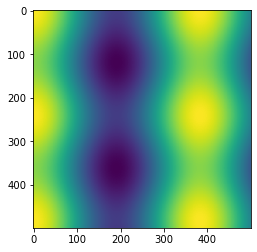

In [16]:
import math
def getZone(x,y):
    zoneSize = int(db.getParameter('ZoneSize'))
    print(f"ZoneSize={zoneSize}")
    return (zoneSize, math.floor(x/zoneSize), math.floor(y/zoneSize))

def generate(x,y, coeffs, denom, intercept):
    sum = 0
    num_coeffs = int(len(coeffs)/2)
    #print(type(num_coeffs),num_coeffs)
    for i in range(0,num_coeffs*2,2):
        sum += coeffs[i] * math.cos( x / denom[i] ) + intercept[i]
        sum += coeffs[i+1] * math.cos( y / denom[i+1] ) + intercept[i+1]
    return sum

def getWorldParameters(x,y):
    zoneSize, startx, starty = getZone(x,y)
    startx = startx * zoneSize
    starty = starty * zoneSize
    print(zoneSize, startx, starty)
    #zoneSize = 500
    
    coeff_str = db.getWorldState('coeffs')
    denom_str = db.getWorldState('denom')
    intercepts_str = db.getWorldState('intercepts')
    coeffs = list(map(float,coeff_str.split(',')))
    denom = list(map(float,denom_str.split(',')))
    intercepts = list(map(float,intercepts_str.split(',')))
    print(coeffs)
    print(denom)
    print(intercepts)
    array = np.zeros((zoneSize,zoneSize))
    start = 0
    for x in range(start,zoneSize+start):
        for y in range(start,zoneSize+start):
            array[y-start][x-start] = generate(x+1,y+1, coeffs, denom, intercepts)
    
    #array = np.array(array)
    if 1:
        array = array.reshape(-1, 1) 
        scaler = MinMaxScaler()
        array = scaler.fit_transform(array)
        array = array * 255
        array = array.astype(int)
        array = array.reshape(zoneSize,zoneSize)
        #array = np.squeeze(array)
    print(array.shape)
    print(stats.describe(array,axis=None))
    #print(array)
    plt.imshow(array, cmap='viridis', interpolation='none')
    plt.show()
    return array

def generateZone(x,y):
    zoneSize, startx, starty = getZone(x,y)
    startx = startx * zoneSize
    starty = starty * zoneSize
    print(zoneSize, startx, starty)
    
generateZone(140,420)
zoneArray = getWorldParameters(225,225)

In [18]:
zoneArray.shape

(500, 500)

In [20]:
db.query('select * from tile_types;')

[(1, 'water', 0, 50, '{"background-color": "blue"}'),
 (2, 'sand', 51, 75, '{"background-color": "yellow"}'),
 (3, 'rock', 76, 100, '{"background-color": "gray"}'),
 (4, 'gold', 100, 110, '{"background-color": "gold"}'),
 (5, 'dirt', 111, 150, '{"background-color": "brown"}'),
 (6, 'grass', 151, 225, '{"background-color": "green"}'),
 (7, 'lavarock', 226, 240, '{"background-color": "black"}'),
 (8, 'lava', 241, 255, '{"background-color": "red"}')]

In [46]:
tile_types = db.query('select * from tile_types;')
def getTileType(value, tile_types):
    for tile_type in tile_types:
        if value >= tile_type[2] and value <= tile_type[3]:
            return tile_type[0]
    return -1

In [51]:
getTileType(288,tile_types)

-1

In [100]:
def writeZoneArray(zoneArray, db):
    tile_types = db.query('select * from tile_types;')
    
    tiles = []
    for ix, iy in np.ndindex(zoneArray.shape):
        tiles.append((
            ix, 
            iy, 
            getTileType(int(zoneArray[ix, iy]), tile_types)
        ))
    stmt = "insert ignore into tiles (x,y,type_id) VALUES (%s, %s, %s);"
    db.cursor.executemany(stmt, list(tiles))
    db.connection.commit()
    
writeZoneArray(zoneArray,db)

In [21]:
db.query('show tables;')

[('params',), ('positions',), ('tile_types',), ('tiles',), ('world_state',)]

In [22]:
db.query('describe positions;')

[('id', 'int(11)', 'NO', 'PRI', None, 'auto_increment'),
 ('x', 'int(11)', 'YES', '', '0', ''),
 ('y', 'int(11)', 'YES', '', '0', ''),
 ('z', 'int(11)', 'YES', '', '0', '')]

In [58]:
db.query('describe tiles;')

[('x', 'int(11)', 'NO', 'PRI', None, ''),
 ('y', 'int(11)', 'NO', 'PRI', None, ''),
 ('type_id', 'int(11)', 'NO', '', None, '')]

In [79]:
stmt = "insert into tiles (x,y,type_id) VALUES (%s, %s, %s);"
values = [(2,3,1),(2,4,1)]
db.cursor.executemany(stmt, values)

In [80]:
db.connection.commit()

In [81]:
db.query("select * from tiles")

[(1, 1, 1), (1, 2, 1), (2, 3, 1), (2, 4, 1)]